In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
base= pd.read_csv("fb_stocks.csv")

In [39]:
base.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [40]:
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,27.440001,28.180000,27.420000,28.000000,28.000000,69846400
1,2013-01-03,27.879999,28.469999,27.590000,27.770000,27.770000,63140600
2,2013-01-04,28.010000,28.930000,27.830000,28.760000,28.760000,72715400
3,2013-01-07,28.690001,29.790001,28.650000,29.420000,29.420000,83781800
4,2013-01-08,29.510000,29.600000,28.860001,29.059999,29.059999,45871300


In [0]:
base_treinamento= base.iloc[:,1:7].values

In [0]:
normalizador= MinMaxScaler(feature_range=(0,1))

In [0]:
base_treinamento_normalizada=normalizador.fit_transform(base_treinamento)

In [0]:
previsores=[]
preco_real=[]

In [45]:
base.shape

(1761, 7)

In [0]:
for i in range(90,1761):
  previsores.append(base_treinamento_normalizada[i-90:i,0:6])
  preco_real.append(base_treinamento_normalizada[i,0])
previsores, preco_real=np.array(previsores), np.array(preco_real)

In [0]:
regressor=Sequential()

In [0]:
regressor.add(LSTM(units=100,return_sequences=True, input_shape=(previsores.shape[1],6)))
regressor.add(Dropout(0.3))

In [0]:
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))

In [0]:
regressor.add(Dense(units=1, activation='sigmoid'))
regressor.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error'])


In [0]:
early= EarlyStopping(monitor='loss',min_delta=1e-10,patience=10,verbose=1)
redu= ReduceLROnPlateau(monitor='loss',factor=0.2,patience=5,verbose=1)
mcp= ModelCheckpoint(filepath='pesos.h5',monitor='loss')

In [64]:
regressor.fit(previsores,preco_real,epochs=1000, batch_size=32,callbacks=[early,redu,mcp])

Epoch 1/1000
1671/1671 [==============================] - 16s 10ms/step - loss: 0.0169 - mean_absolute_error: 0.0928
Epoch 2/1000
1671/1671 [==============================] - 15s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0408
Epoch 3/1000
1671/1671 [==============================] - 16s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0385
Epoch 4/1000
1671/1671 [==============================] - 16s 10ms/step - loss: 0.0024 - mean_absolute_error: 0.0377
Epoch 5/1000
1671/1671 [==============================] - 16s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0380
Epoch 6/1000
1671/1671 [==============================] - 16s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0384
Epoch 7/1000
1671/1671 [==============================] - 16s 10ms/step - loss: 0.0019 - mean_absolute_error: 0.0337
Epoch 8/1000
1671/1671 [==============================] - 16s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0336
Epoch 9/1000
1671/1671 [==============================] - 16s 9ms/st

In [0]:
base_teste=pd.read_csv('fb_stocks_test.csv')
preco_real=base_teste.iloc[:,1:2].values
frames=[base,base_teste]
base_completa=pd.concat(frames)
base_completa=base_completa.drop('Date',axis=1)

In [0]:
preco_real_teste= base_teste.iloc[:,1:2].values

In [0]:
entradas= base_completa[len(base_completa)-len(base_teste)-90:].values

In [0]:
entradas= normalizador.transform(entradas)

In [0]:
X_teste=[]
for i in range(90,178):
  X_teste.append(entradas[i-90:i,0:6])
X_teste=np.array(X_teste)

In [73]:
normalizador_previsao=MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.0230893 ],
       [0.02537228],
       [0.0260468 ],
       ...,
       [0.94733568],
       [0.96342031],
       [0.95921756]])

In [0]:
previsoes= regressor.predict(X_teste)
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [75]:
previsoes.mean()

186.98021

In [76]:
preco_real.mean()

192.9284090340909

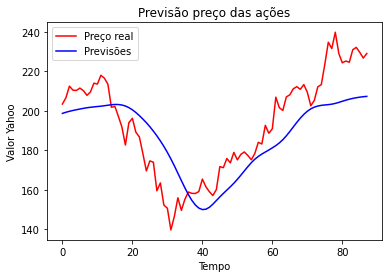

In [77]:
plt.plot(preco_real_teste,color='red',label='Preço real')
plt.plot(previsoes,color='blue',label='Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()